### Hello There!
Below is the code for the detection and characterization of benzodiazepine use.

The purpose of this file is to train the data on a 1D CNN

# Set up

In [ ]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import os
from IPython.display import clear_output

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
#from keras.layers.embeddings import Embedding
from keras.metrics import AUC

# Tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import random

# Import Layers
from keras.layers import ConvLSTM2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import MaxPooling3D

Seed

In [ ]:
# Hard Code Random Seeds.
r1 = 0
r2 = 1

# Set Random Seed
random.seed(r1)
tf.random.set_seed(r2)

Root folder to save info

In [ ]:
root = "/content/drive/MyDrive/Colab Notebooks/Benzos Classification/Reference Models/CNN Data/"

### TPU Configuration

In [ ]:
# @title TPU Configuration
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

# ----------
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

with tf.device('/TPU:0'):
  c = tf.matmul(a, b)

print("c device: ", c.device)
print(c)
# ----------

strategy = tf.distribute.TPUStrategy(resolver)

# ----------
@tf.function
def matmul_fn(x, y):
  z = tf.matmul(x, y)
  return z

z = strategy.run(matmul_fn, args=(a, b))
print(z)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
c device:  /job:worker/replica:0/task:0/device:TPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


PerReplica:{
  0: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  1: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  2: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  3: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  4: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  5: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  6: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  7: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
}


# Data Processing

Mount to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Data

In [ ]:
# Load Data X
Wide_X = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Benzos Classification/Data/[Smooth]SEQN_WideX.parquet')
SEQN = Wide_X['SEQN']
Wide_X = Wide_X.drop(columns=['SEQN'])

# Process X --------
data_wide = Wide_X

# Standard Scalar
scaler = StandardScaler()
scaler.fit(data_wide)
data_wide = scaler.transform(data_wide)

# Convert DF to array
data_wide = np.array(data_wide)

In [ ]:
# Load Data Y
## Let's adjust this so not to pull in separate Y data frame; merge on SEQN
Y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Benzos Classification/Data/new_benzo_y.csv')

# Process Y --------
# Drop Unnamed Column
Y = Y.drop("Unnamed: 0", axis = 1)
Y.head()

# Change to Y Float
Y['Benzo'] = Y['y'].apply(lambda x: float(x))

#Make y array as well
y = np.hstack(np.asarray(Y.Benzo)).reshape(len(Y),1)

Numbers:

In [ ]:
# Shape Analysis
print("shape of X:", data_wide.shape)
print("shape of y:", y.shape)
# Class Analysis
benzoUse = int(sum(y))
total = int(len(y))
benzoNoUse = int(total-benzoUse)

print("Benzo Use:", benzoUse, "participants")
print("Benzo No Use:", benzoNoUse, "participants")

shape of X: (7162, 10080)
shape of y: (7162, 1)
Benzo Use: 137 participants
Benzo No Use: 7025 participants


Train test split

In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(data_wide, y, test_size=0.2, stratify=y, random_state = 19) # Hard coded random seed

# Reshape Train and Test
n_participants_train = X_train.shape[0]
n_participants_test = X_test.shape[0]
n_timesteps = X_train.shape[1]
n_features = 1

# Reshape
X_train = X_train.reshape((n_participants_train, n_timesteps, n_features))
X_test = X_test.reshape((n_participants_test, n_timesteps, n_features))

# Model Architecture

In [ ]:
#Make Model
def create_model():
  model = tf.keras.Sequential()

  # Conv Layers
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                    input_shape=(10080, 1)))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())

  # Feed Forward Layers
  model.add(Dense(100, activation='relu'))
  model.add(tf.keras.layers.Dropout(rate=0.2))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  return model

## Compilation

In [ ]:
# Compile the model -----
with strategy.scope():
  # Create the model we defined above
  model = create_model()
  # Compile
  model.compile(
    # Metrics
    loss= tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics= tf.keras.metrics.AUC(name='auc'),
    # Optimizer
    optimizer= tf.keras.optimizers.Adam(
      learning_rate=0.00001,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      amsgrad=False,
    )
)

model.summary()
model.save_weights(root + "base_model_weights.h5")

def reset_model():
  model.load_weights(root + "base_model_weights.h5")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10078, 64)         256       
                                                                 
 conv1d_1 (Conv1D)           (None, 10076, 64)         12352     
                                                                 
 dropout (Dropout)           (None, 10076, 64)         0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5038, 64)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 322432)            0         
                                                                 
 dense (Dense)               (None, 100)               32243300  
                                                        

Set Parameters

In [ ]:
# Params ----------
# Balance Weights
class_weights = {0: (benzoUse/total),  # Custom Setting Class Weights
                1: (benzoNoUse/total)}

# Early Stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc',
                                            patience=90,
                                            restore_best_weights=True,
                                            )

## Fit the Model

In [ ]:
# Fit the Model
histories = []
def fit_model(X_training, y_training, X_val, y_val):
  history = model.fit(
      X_training, y_training,
      epochs= 250,
      batch_size= 64,
      validation_data = (X_val, y_val),
      shuffle=False,
      class_weight=class_weights,
      callbacks = [callback],
      verbose = 2
  )
  histories.append(history)

In [ ]:
# Save the model
def save_model(count):
  model.save(root + "full_model_" + str(count) + ".h5")
  model.save_weights(root + "weights_" + str(count) +".hdf5")

In [ ]:
# Model Evaluation
def model_eval():
  print(" \n-\n-\n-\n-\n-\n-\n-\n-\n-\ntest set:")
  scores = model.evaluate(X_test, y_test, batch_size=64) # Test Set
  cv_test_scores.append(scores[1])
  y_pred_test = model.predict(X_test)


  print(" \n-\n-\n-\n-\n-\n-\n-\n-\n-\nval set:")
  scores = model.evaluate(X_val, y_val, batch_size=64)  # Validation Set
  cv_val_scores.append(scores[1])
  y_pred_val = model.predict(X_val)

  return y_pred_test, y_pred_val

  #Return predictions

In [ ]:
# Save all predictions and file
def save_files(count):
  # Preds
  pred_filepath = root
  np.save(pred_filepath + "/y_pred_test_" + str(count) + ".npy", y_pred_test, allow_pickle=True)
  np.save(pred_filepath + "/y_pred_val_" + str(count) + ".npy", y_pred_val, allow_pickle=True)

  # Train
  train_filepath = root
  np.save(train_filepath + "/X_train_" + str(count) + ".npy", X_training, allow_pickle=True)
  np.save(train_filepath + "/y_train_" + str(count) + ".npy", y_training, allow_pickle=True)

  # Test
  test_filepath = root
  np.save(test_filepath + "/X_test_" + str(count) + ".npy", X_test, allow_pickle=True)
  np.save(test_filepath + "/y_test_" + str(count) + ".npy", y_test, allow_pickle=True)

  # Validation
  val_filepath = root
  np.save(val_filepath + "/X_val_" + str(count) + ".npy", X_val, allow_pickle=True)
  np.save(val_filepath + "/y_val_" + str(count) + ".npy", y_val, allow_pickle=True)




# 10 fold Cross Val

In [ ]:
#@title K-Fold CV Model
%%time
from sklearn.model_selection import StratifiedKFold

# Global Score List Buckets
cv_test_scores=[]
cv_val_scores=[]

# K fold parameters
seed = 2
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

# run K-fold
count = 1
for train, val in kfold.split(X_train, y_train):

  # Create New Training Set
  X_training = X_train[train]
  y_training = y_train[train]
  # Create new Validation Sets
  X_val = X_train[val]
  y_val = y_train[val]

  # Reset model
  print("Resetting model..")
  reset_model()
  # Fit model
  fit_model(X_training, y_training, X_val, y_val)
  # Eval model
  y_pred_test, y_pred_val = model_eval()
  # Save model
  print("Saving model...")
  save_model(count)
  # Save files
  print("Saving files...")
  save_files(count)

  # increment
  print("FINISHED CYCLE NUMBER:", count)
  count += 1

# Score Eval
print("\nCV Test AUC----------------------------")
print("Individual scores:", cv_test_scores)
print("Mean:", np.mean(cv_test_scores))
print("std:", np.std(cv_test_scores))
print("\nCV Val AUC-----------------------------")
print("Individual scores:", cv_val_scores)
print("Mean:", np.mean(cv_val_scores))
print("std:", np.std(cv_val_scores))

Resetting model..
Epoch 1/250
81/81 - 24s - loss: 0.0260 - auc: 0.6606 - val_loss: 0.6626 - val_auc: 0.7805 - 24s/epoch - 294ms/step
Epoch 2/250
81/81 - 3s - loss: 0.0234 - auc: 0.6763 - val_loss: 0.6612 - val_auc: 0.7975 - 3s/epoch - 39ms/step
Epoch 3/250
81/81 - 3s - loss: 0.0222 - auc: 0.7185 - val_loss: 0.6309 - val_auc: 0.8028 - 3s/epoch - 40ms/step
Epoch 4/250
81/81 - 4s - loss: 0.0212 - auc: 0.7466 - val_loss: 0.5866 - val_auc: 0.8218 - 4s/epoch - 44ms/step
Epoch 5/250
81/81 - 3s - loss: 0.0203 - auc: 0.7697 - val_loss: 0.5762 - val_auc: 0.8279 - 3s/epoch - 39ms/step
Epoch 6/250
81/81 - 3s - loss: 0.0191 - auc: 0.8053 - val_loss: 0.5617 - val_auc: 0.8330 - 3s/epoch - 39ms/step
Epoch 7/250
81/81 - 3s - loss: 0.0182 - auc: 0.8266 - val_loss: 0.5449 - val_auc: 0.8365 - 3s/epoch - 39ms/step
Epoch 8/250
81/81 - 3s - loss: 0.0177 - auc: 0.8402 - val_loss: 0.5178 - val_auc: 0.8356 - 3s/epoch - 36ms/step
Epoch 9/250
81/81 - 3s - loss: 0.0170 - auc: 0.8489 - val_loss: 0.5143 - val_auc: 0

# Some Figures

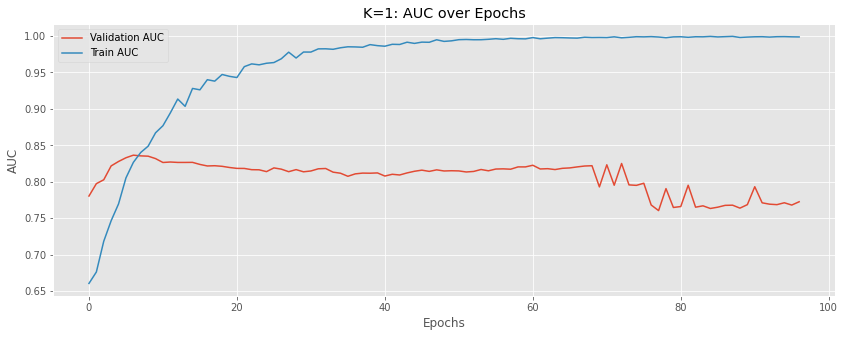

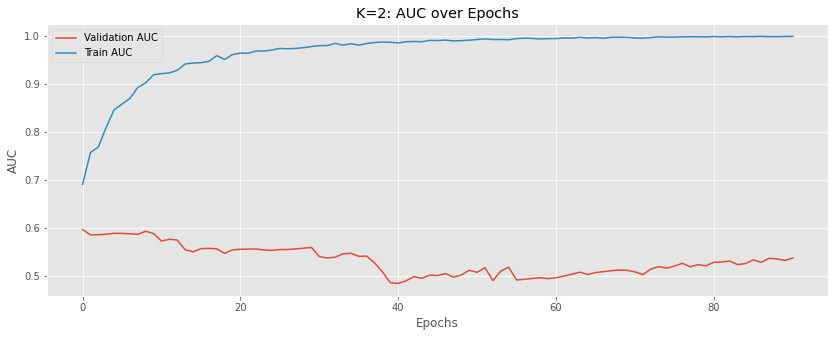

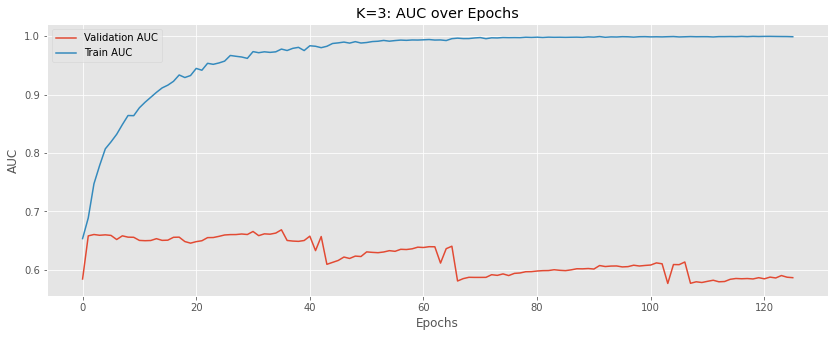

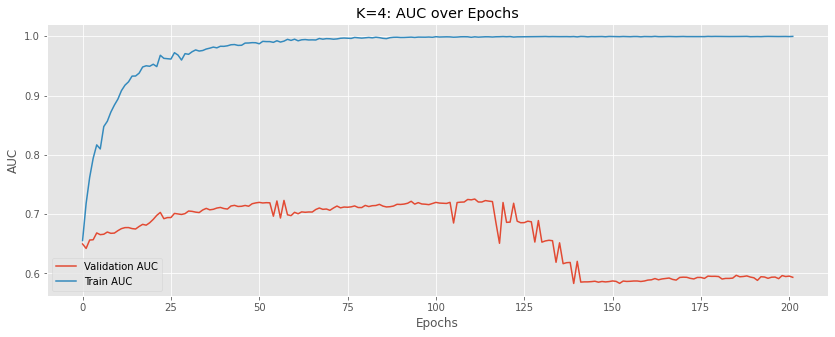

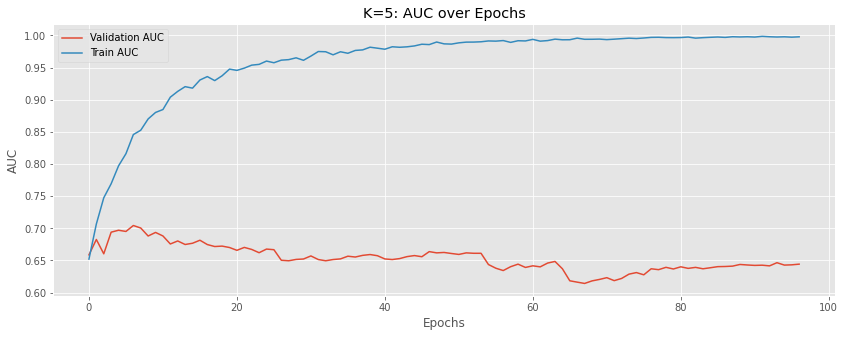

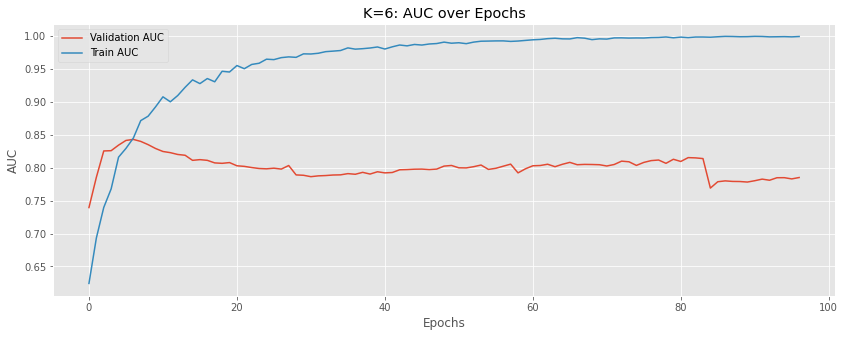

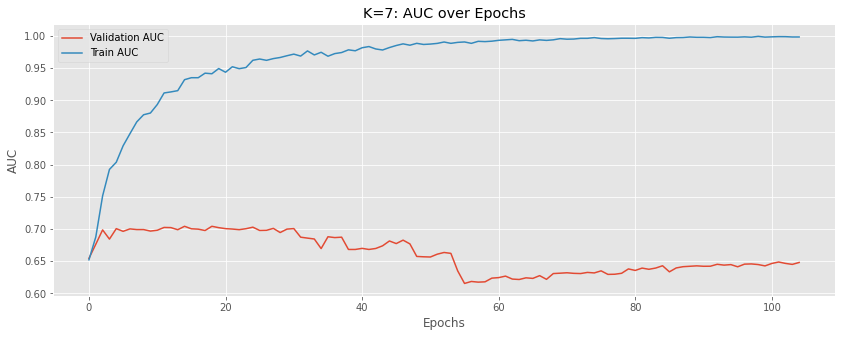

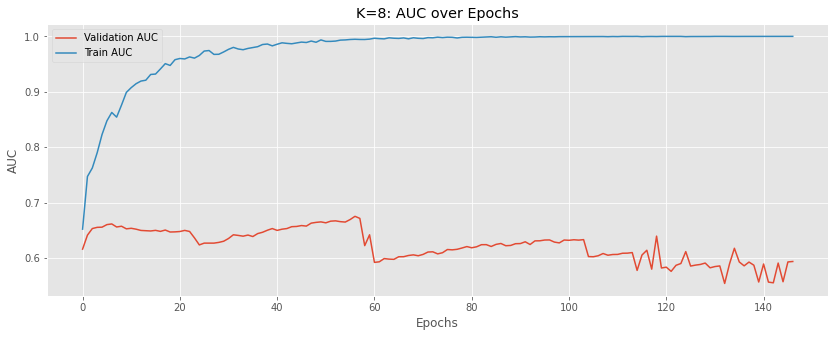

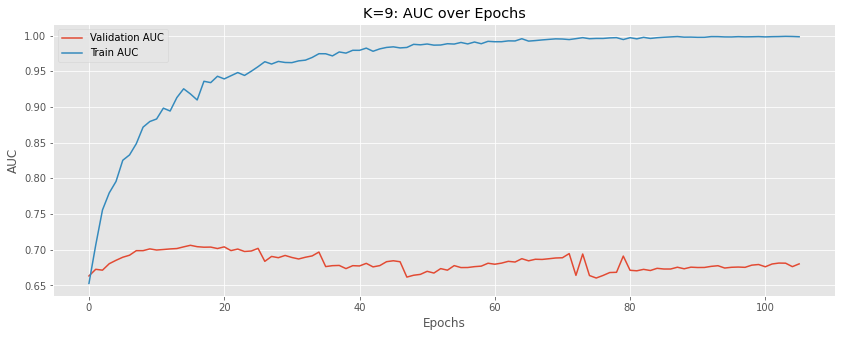

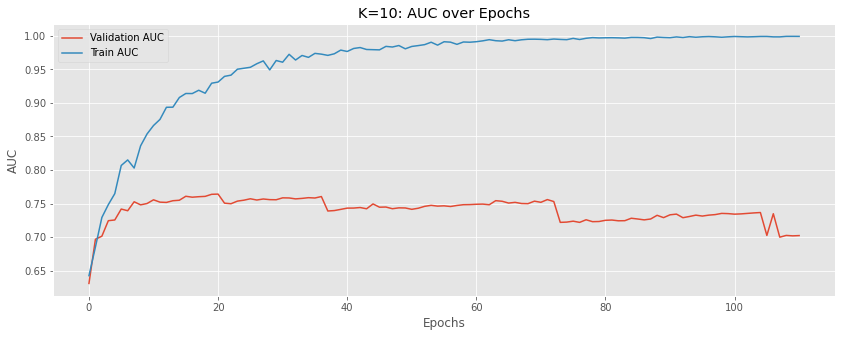

In [ ]:
# Style Sheet
plt.style.use('ggplot')

# Plot AUC and Loss
count = 1
for history in histories:
  plt.figure(figsize=(14,5))
  plt.title("K=" + str(count) + ": AUC over Epochs")
  plt.ylabel("AUC")
  plt.xlabel("Epochs")
  plt.plot(history.history['val_auc'], label='Validation AUC')
  plt.plot(history.history['auc'], label='Train AUC')
  plt.legend()

  count+=1

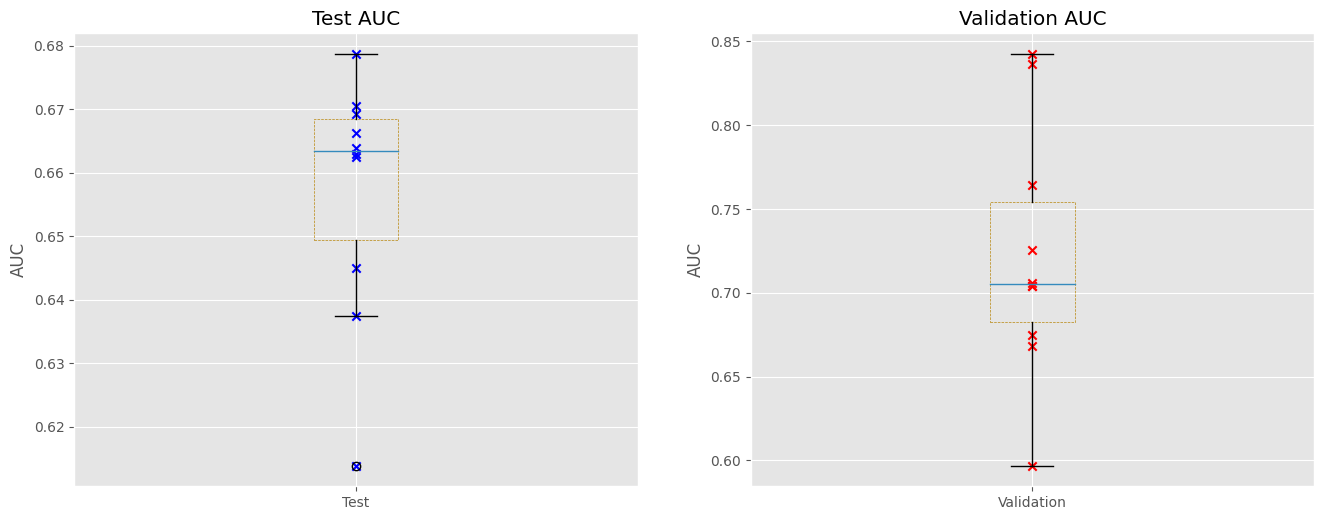

In [ ]:
fig = plt.figure(figsize=(16,6), dpi=100)

plt.subplot(1,2,1)
plt.title("Test AUC")
plt.ylabel("AUC")
boxprops = dict(linestyle='--', linewidth=.5, color='darkgoldenrod')
plt.boxplot([cv_test_scores], boxprops=boxprops)
clear_output()
plt.xticks([1], ['Test'])

# Test
for value in (cv_test_scores):
  plt.scatter(1, value, marker='x', c='blue')

# Validation
plt.subplot(1,2,2)
plt.title("Validation AUC")
plt.ylabel("AUC")
boxprops = dict(linestyle='--', linewidth=.5, color='darkgoldenrod')
plt.boxplot([cv_val_scores], boxprops=boxprops)
clear_output()
plt.xticks([1], ['Validation'])

# Val
for value in (cv_val_scores):
  plt.scatter(1, value, marker='x', c='red')

